In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('img/style.mplstyle')

In [2]:
scratch_base = '/pscratch/sd/j/jrobnik/'
scratch = scratch_base + 'quasars_scratch/'
dir_data = scratch_base + 'quasars/'
dir_results = 'data/'

ids = np.load(dir_data + 'ids.npy')

data = pd.read_csv('data/real_0_0.csv').sort_values('logB', ascending=False)
data1 = pd.read_csv('data/real_1_0.csv').('logB', ascending=False)
#data2 = pd.read_csv('data/real_2_0.csv').sort_valuessort_values('logB', ascending=False)

def remove_failure(df):
    success = np.array(df['success'])
    print(np.sum(success) / len(df))
    return df[df['success']]

data = remove_failure(data)
data1 = remove_failure(data1)


info = pd.read_csv(dir_data + 'quasar_info.txt', delim_whitespace=True)
data = pd.merge(data, info, on= 'id')

0.9882712036853857
0.8075629539609417


In [ ]:
for istat in range(2):
    plt.figure(figsize= (20, 8))
    ff = 26
    plt.yticks(fontsize=ff)
    plt.xticks(fontsize=ff)

    stat = ['logB', 'log_lik_ratio'][istat]
    xlabel = [r'$\log B$', 'log-likelihood ratio'][istat]  
    save_name = 'img/results' + ['', '_loglik'][istat]  
    
    for imode in range(2):
        df = [data, data1][imode]
        name = ['real', 'null template 1', 'null template 2'][imode]
    
        x = np.array(df[stat])
        x = x[np.isfinite(x)]
        plt.hist(x, cumulative= -1, histtype= 'step', bins = len(df), label= name, lw= 5)
    
    plt.xlim(0, np.max(x))
    plt.legend(fontsize= ff)
    plt.xlabel(xlabel, fontsize = ff)
    plt.ylabel('cumulative count', fontsize= ff)
    plt.yscale('log')
    plt.savefig(save_name)
    plt.show()

In [ ]:
import jax
import jax.numpy as jnp

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True) # since we are on cpu we do not mind using 64 bits

from LombScargle import periodogram
from quasars.prep import load_data


def get_temp(temp_num, id):
    if temp_num == 0:
        return periodogram.basic
    else:
        job_id = jnp.argmin(jnp.abs(ids - id))
        key= jax.random.split(jax.random.key(42), 10 * len(ids)).reshape(10, len(ids))[temp_num][job_id]
        return periodogram.randomized_period(key, 2000, concentration= 3.)


def plot_fit(results, temp_num):

    amp = np.array(results[['A_const', 'A_sin', 'A_cos']])
    freq_best = 1./results['period']
    id = results['id']
    
    time, mag, mag_err, _, _ = load_data(id)

    plt.title('id: ' + str(id))
    plt.errorbar(time, mag, mag_err, fmt = '.', capsize = 1.3, color= 'black', label= 'data')
    t = jnp.linspace(jnp.min(time), jnp.max(time), 1000)
    
    model = periodogram.fit(t, freq_best, amp, temp_func= get_temp(temp_num, id))
    plt.plot(t, model, color = ['teal', 'xkcd:ruby', 'xkcd:ruby'][temp_num], label= 'model')
    plt.gca().invert_yaxis()

plt.figure(figsize = (20, 6))
    
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plot_fit(data.iloc[i], temp_num= 0)
    plt.subplot(2, 5, i + 6)
    plot_fit(data1.iloc[i], temp_num= 1)
plt.show()

In [4]:
info = pd.merge(info, data[['id', 'log_prior_odds']], on= 'id')

In [7]:
info.to_csv(dir_data + 'quasar_info.csv')

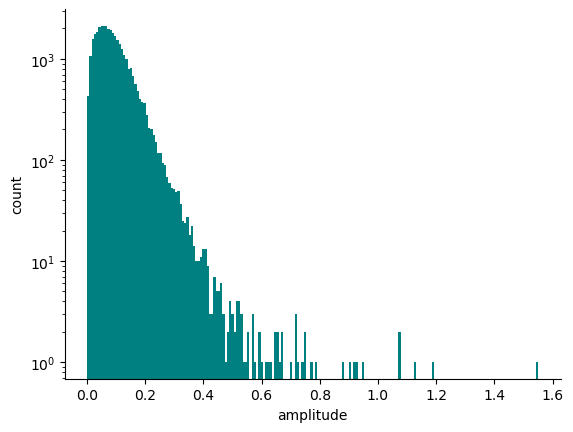

In [8]:
A = np.sqrt(np.square(data['A_cos']) + np.square(data['A_sin']))
plt.hist(A, bins = 200)
plt.yscale('log')
plt.xlabel('amplitude')
plt.ylabel('count')
plt.show()

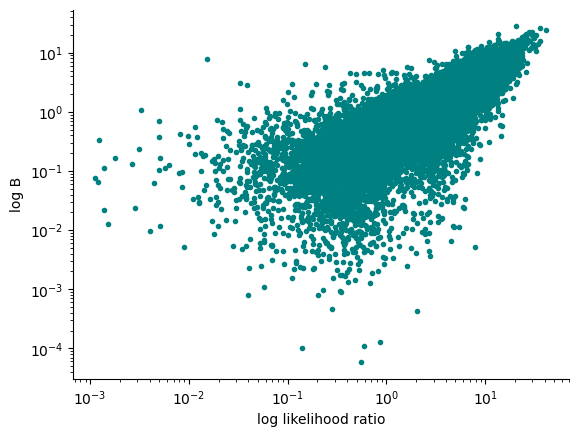

In [10]:
mask = np.isfinite(data['logB']) & (data['logB'] > 0.) #& (data['log_lik_ratio'] > 0.)
plt.plot(np.array(data['log_lik_ratio'])[mask], np.array(data['logB'])[mask], '.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log likelihood ratio')
#plt.xlim(1e-3, 100.)
plt.ylabel('log B')

plt.show()

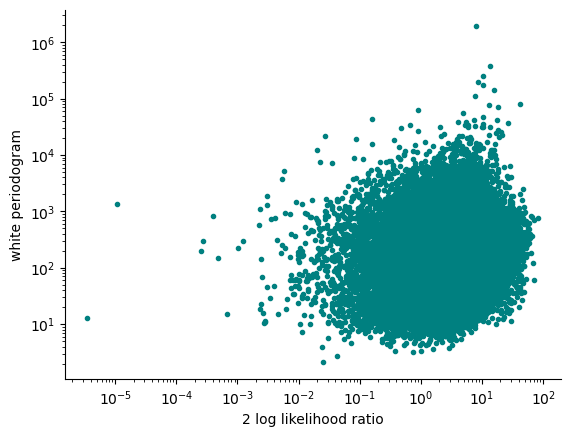

In [11]:
plt.plot(2 * np.array(data['log_lik_ratio']), np.array(data['white_periodogram']), '.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('2 log likelihood ratio')
plt.ylabel('white periodogram')
plt.show()

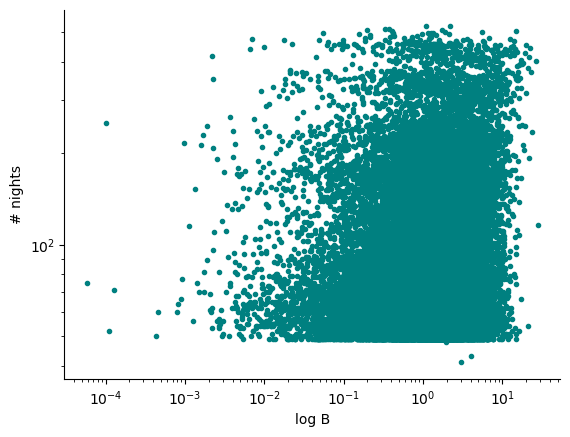

In [15]:
plt.plot(np.array(data['logB']), np.array(data['data_points']), '.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log B')
plt.ylabel('# nights')
plt.show()

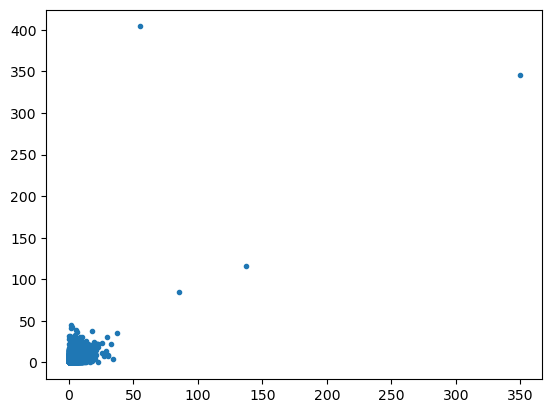

In [4]:
# are the same quasars detected on null and periodic?

data_both = data.merge(data2, on= 'id')
mask = np.isfinite(data_both['logB_x']) & np.isfinite(data_both['logB_y']) & (data_both['logB_x'] > 0) & (data_both['logB_y'] > 0)
plt.plot(np.array(data_both['logB_x'])[mask], np.array(data_both['logB_y'])[mask], '.')